## SINGLE NOTEBOOK — FULL CNN WITH ALL CONVOLUTIONS

You can paste this as-is into one notebook and run top → bottom.


### Cell 1 — Imports & Setup

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.signal import convolve2d
from matplotlib.animation import PillowWriter

os.makedirs("gifs", exist_ok=True)


### Cell 2 — Load Image

In [2]:
img = Image.open("./Images/B.jpg").convert("L")
img = img.resize((64, 64))
x = np.array(img, dtype=float) / 255.0

print("Input:", x.shape)


Input: (64, 64)


### Cell 3 — CNN Utilities (SAFE)

In [3]:
def conv2d(img, kernel):
    return convolve2d(img, kernel, mode="valid")

def relu(x):
    return np.maximum(0, x)

def maxpool(x, size=2):
    h, w = x.shape
    h_trim = (h // size) * size
    w_trim = (w // size) * size
    x = x[:h_trim, :w_trim]

    pooled = np.zeros((h_trim // size, w_trim // size))
    for i in range(0, h_trim, size):
        for j in range(0, w_trim, size):
            pooled[i//size, j//size] = np.max(x[i:i+size, j:j+size])
    return pooled

def normalize_stage(img, eps=1e-8):
    mn, mx = img.min(), img.max()
    if mx - mn < eps:
        return np.zeros_like(img)
    return (img - mn) / (mx - mn)


### Cell 4 — Kernels

In [4]:
kernels = [
    np.array([[1, 0, -1],
              [1, 0, -1],
              [1, 0, -1]]),     # vertical

    np.array([[1, 1, 1],
              [0, 0, 0],
              [-1,-1,-1]]),     # horizontal

    np.array([[0, -1, 0],
              [-1, 4, -1],
              [0, -1, 0]])      # corners
]


### Cell 5 — CNN Forward Pass (STORE EVERYTHING)

In [5]:
stages = []
titles = []

def add_stage(img, title):
    stages.append(normalize_stage(np.abs(img)))
    titles.append(title)

# Input
add_stage(x, "Input Image")

# -------- Block 1 --------
conv1_maps = [conv2d(x, k) for k in kernels]
for i, m in enumerate(conv1_maps):
    add_stage(m, f"Conv1 – Kernel {i+1}")

conv1_sum = sum(conv1_maps)
add_stage(conv1_sum, "Conv1 – Sum")

relu1 = relu(conv1_sum)
add_stage(relu1, "ReLU1")

pool1 = maxpool(relu1)
add_stage(pool1, "MaxPool1")

# -------- Block 2 --------
conv2_maps = [conv2d(pool1, k) for k in kernels]
for i, m in enumerate(conv2_maps):
    add_stage(m, f"Conv2 – Kernel {i+1}")

conv2_sum = sum(conv2_maps)
add_stage(conv2_sum, "Conv2 – Sum")

relu2 = relu(conv2_sum)
add_stage(relu2, "ReLU2")

pool2 = maxpool(relu2)
add_stage(pool2, "MaxPool2")

# -------- Block 3 --------
conv3_maps = [conv2d(pool2, k) for k in kernels]
for i, m in enumerate(conv3_maps):
    add_stage(m, f"Conv3 – Kernel {i+1}")

conv3_sum = sum(conv3_maps)
add_stage(conv3_sum, "Conv3 – Sum")

relu3 = relu(conv3_sum)
add_stage(relu3, "ReLU3")

print("Total stored stages:", len(stages))


Total stored stages: 18


### Cell 6 — GRID + FAST GIF EXPORT

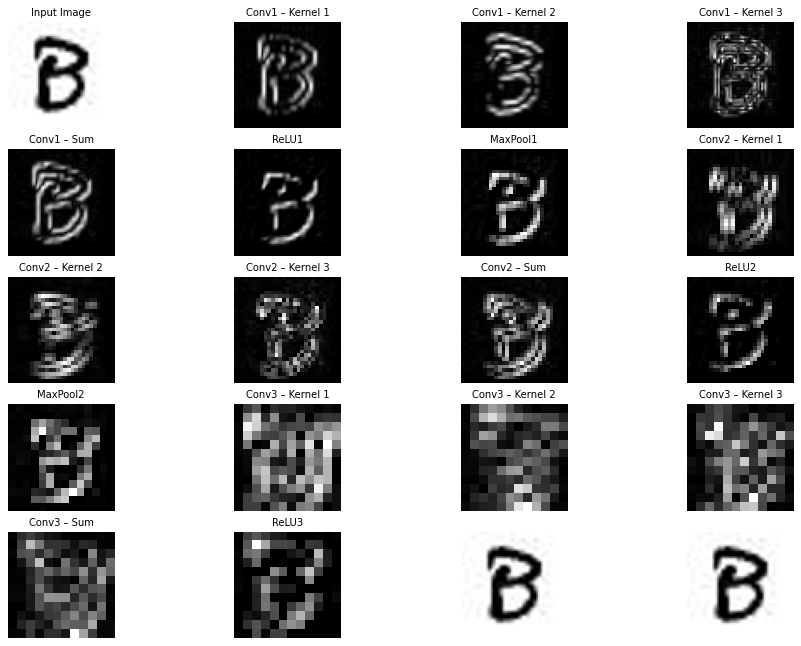

In [6]:
N = len(stages)
COLS = 4
ROWS = int(np.ceil(N / COLS))

fig, axes = plt.subplots(ROWS, COLS, figsize=(14, 10))
axes = axes.flatten()

imgs = []
titles_text = []

for ax in axes:
    ax.axis("off")
    img = ax.imshow(stages[0], cmap="gray", vmin=0, vmax=1)
    title = ax.set_title("", fontsize=9)
    imgs.append(img)
    titles_text.append(title)

def update_grid(frame_idx):
    for i in range(frame_idx + 1):
        imgs[i].set_data(stages[i])
        imgs[i].set_clim(0, 1)
        titles_text[i].set_text(titles[i])

fig.set_dpi(80)
writer = PillowWriter(fps=1)

with writer.saving(fig, "gifs/cnn_all_convolutions.gif", dpi=80):
    for i in range(len(stages)):
        update_grid(i)
        writer.grab_frame()

plt.show()
